# 1 Making the reference catalogues


We need a photometric and astrometric reference. We are going to take the HSC PanSTARRS reference as a base and cross match in the VIDEO JHKs fluxes from HELP. 


The final astrometric reference catalogue will probably be GAIA DR2 astrometry and PanSTARSS plus either 2MASS or the original VISTA catalogues.

In the readme we discuss the changes that have been made to the required format over time. This notebook should show the various changes that we make here including converting fluxes to magnitudes and cross matching in the NIR.


TODO: replace HELP VISTA reference objects with 2MASS.


After this has been done these reference catalogues must be ingested according to the instructions given in the DMU2 readme.

In [1]:
from lsst.meas.algorithms.htmIndexer import HtmIndexer
from lsst.geom import SpherePoint 
from lsst.geom import degrees
from lsst.afw.image import abMagErrFromFluxErr, abMagFromFlux

import numpy as np
from astropy.io import fits
from astropy.table import Table

from collections import OrderedDict

In [48]:
ORIG = ''
PS_CATS = "../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110/"
PS_CATS19 = "../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110_GmagLT19/"
EX_CAT = "../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110/133200.fits"
EX_MS = "../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110/master_schema.fits"
MASS_CAT = '../dmu0/dmu0_2MASS/data/fp_2mass.fp_psc_29182.tbl'

In [3]:
t = Table.read(EX_CAT)

In [4]:
t[:5]

id,coord_ra,coord_dec,parent,g_flux,r_flux,i_flux,z_flux,y_flux,i_fluxSigma,y_fluxSigma,r_fluxSigma,z_fluxSigma,g_fluxSigma,coord_ra_err,coord_dec_err,epoch,pm_ra,pm_dec,pm_ra_err,pm_dec_err,footprint
,rad,rad,,,,,,,,,,,,,,,,,,,
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,int64,float32,float32,float32,float32,int32
101240348703435595,0.6086027636676918,-0.09824488799446053,0,2.6317827632738044e-06,3.6596488826035056e-06,3.995693532488076e-06,2.8654415018536383e-06,1.0687740541470703e-05,5.912674510000215e-07,2.089064537358354e-06,4.5423652750287147e-07,5.176063950784737e-07,4.058150580021902e-07,0.0,0.0,1380284288,0.0,0.0,0.0,0.0,0
101240348719679131,0.6086312254866426,-0.09819358176035808,0,1.9323940705362475e-06,2.114941480613197e-06,3.2428818030894035e-06,2.2691024241794366e-06,2.1629517505061813e-05,9.619166121410672e-07,4.181304120720597e-06,9.779163292478188e-07,1.7406183872026304e-07,2.0141085599334474e-07,0.0,0.0,1380287232,0.0,0.0,0.0,0.0,0
101240348725326683,0.6086389808952766,-0.09823105918415859,0,3.117044570899452e-06,3.830545210803393e-06,3.850464963761624e-06,4.498331691138446e-06,8.078391147137154e-06,2.729729544626025e-07,6.593420039280318e-06,4.2184601056760584e-07,4.5649366597899643e-07,5.326427867657912e-07,0.0,0.0,1366466432,0.0,0.0,0.0,0.0,0
101220348728797983,0.6086474507091528,-0.09850114231813084,0,1.8945245301438263e-06,8.214324225264136e-06,1.5255986909323838e-05,1.8216373064205982e-05,2.5504414224997163e-05,4.367411179373448e-07,1.7010578403642285e-06,6.084546839701943e-07,7.225854687931133e-07,6.369347715917684e-07,0.0,0.0,1363572864,-0.0071392995,-0.007713793,0.014461852,0.014395495,0
101220348739597084,0.6086658816126116,-0.09851299344534954,0,2.819050678226631e-06,9.453086022404023e-06,4.5048411266179755e-05,9.451332152821124e-05,0.00013261307321954519,4.063334131387819e-07,1.0634481668603257e-06,4.5210956045593775e-07,1.3810183645546203e-06,4.077786854850274e-07,0.0,0.0,1418507264,0.016156051,0.0050059482,0.0040425425,0.002666546,0


In [5]:
def getShards(ra, dec, radius):
    htm = HtmIndexer(depth=7)
    shards, onBoundary = htm.getShardIds(SpherePoint(ra*degrees, dec*degrees), radius*degrees)
    return shards
s = getShards(35.428,  -4.90777, 3.0)
s

array([133188, 133200, 133201, 133202, 133203, 133204, 133205, 133206,
       133207, 133208, 133209, 133210, 133211, 133212, 133213, 133214,
       133215, 133234, 133240, 133241, 133243, 133245, 133280, 133281,
       133282, 133283, 133288, 133289, 133291, 133293, 133294, 133295,
       133312, 133313, 133314, 133315, 133316, 133317, 133318, 133319,
       133320, 133321, 133322, 133323, 133324, 133325, 133326, 133327,
       133365, 133368, 133370, 133371, 133372, 133968, 133970, 133971,
       134024, 134048, 134049, 134050, 134051, 134052, 134053, 134054,
       134055, 134057, 134058, 134059, 134060, 134061, 134062, 134063,
       134065, 134068, 134070, 134071, 134078, 134080, 134081, 134083,
       133189, 133190, 133191, 133224, 133232, 133233, 133235, 133242,
       133244, 133246, 133247, 133268, 133285, 133286, 133287, 133290,
       133292, 133296, 133297, 133299, 133336, 133338, 133339, 133348,
       133364, 133366, 133367, 133369, 133373, 133374, 133375, 133969,
      

In [6]:
#Everything in SXDS DUD region
ps_refcats = getShards(36.,  -5.0, 3.0)
files = ''
for c in ps_refcats:
    files += '{}.fits,'.format(c)
print('scp ir-shir1@login.hpc.cam.ac.uk:~/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu0/dmu0_PanSTARRS/data/ps1_pv3_3pi_20170110/\{'
      +files+'\} ./')

scp ir-shir1@login.hpc.cam.ac.uk:~/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu0/dmu0_PanSTARRS/data/ps1_pv3_3pi_20170110/\{133200.fits,133201.fits,133202.fits,133203.fits,133204.fits,133205.fits,133206.fits,133207.fits,133208.fits,133209.fits,133210.fits,133211.fits,133212.fits,133213.fits,133214.fits,133215.fits,133232.fits,133234.fits,133235.fits,133240.fits,133241.fits,133243.fits,133245.fits,133268.fits,133280.fits,133281.fits,133282.fits,133283.fits,133288.fits,133289.fits,133290.fits,133291.fits,133292.fits,133293.fits,133294.fits,133295.fits,133296.fits,133297.fits,133299.fits,133312.fits,133313.fits,133314.fits,133315.fits,133316.fits,133317.fits,133318.fits,133319.fits,133320.fits,133321.fits,133322.fits,133323.fits,133324.fits,133325.fits,133326.fits,133327.fits,133336.fits,133364.fits,133365.fits,133367.fits,133368.fits,133369.fits,133370.fits,133371.fits,133372.fits,133373.fits,133375.fits,133968.fits,134048.fits,134049.fits,134050.fits,134051.fits,134052.fits,134053.fits,1

In [7]:
def clean_table(table):
    """Take a table produced by a VO query and remove all empty columns
    
    Often many columns are empty and make the tables hard to read.
    The function also converts columsn that are objects to strings.
    Object columns prevent writing to fits.
    
    Inputs
    =======
    table,    Astropy.table.Table
        The input table
    
    Returns
    =======
    table,    Astropy.table.Table
         The modified table.
    
    """
    table = table.copy()
    if len(table) == 0:
        return table
    for col in table.colnames:
        #Remove empty columns
        try:
            if np.all(table[col].mask):
                print("Removing empty column: {}".format(col))
                table.remove_column(col)
                continue
        except AttributeError:
            print("{} is not a masked columns".format(col))
            
        #Get rid of column type object from VO queries
        if table[col].dtype == 'object':
            print("Converting column {} type from object to string".format(col) )
            table[col] = table[col].astype(str)
 
        #Get rid of unit '-' from some tables
        if table[col].unit == '-':
            print("Converting column {} unit from '-' to None".format(col) )
            table[col].unit = None   
            
        #replace masked floats with nans     
        if (
            (table[col].dtype == float) 
            or (table[col].dtype == 'float32')
            or (table[col].dtype == 'float64')
        ):
            table[col].fill_value = np.nan
    
    table = table.filled()
            
    return table

In [8]:
# Bands: Y,J,H,K
imported_columns = OrderedDict({
        'SOURCEID': "id",
        'ra': "ra",
        'dec': "dec",
        'PSTAR':  "stellarity",
        #'YPETROMAG': "m_vhs_y", 
        #'YPETROMAGERR': "merr_vhs_y", 
        #'YAPERMAG3': "m_ap_vista_y", 
        #'YAPERMAG3ERR': "merr_ap_vista_y",
        #'JPETROMAG': "m_vhs_j", 
        #'JPETROMAGERR': "merr_vhs_j", 
        'JAPERMAG3': "m_ap_vista_j", 
        'JAPERMAG3ERR': "merr_ap_vista_j",        
        #'HPETROMAG': "m_vhs_h", 
        #'HPETROMAGERR': "merr_vhs_h", 
        'HAPERMAG3': "m_ap_vista_h", 
        'HAPERMAG3ERR': "merr_ap_vista_h",        
        #'KSPETROMAG': "m_vhs_k", 
        #'KSPETROMAGERR': "merr_vhs_k", 
        'KSAPERMAG3': "m_ap_vista_ks", 
        'KSAPERMAG3ERR': "merr_ap_vista_ks",
    })


catalogue = Table.read('../dmu0/dmu0_VISTA/dmu0_VHS/data/VHS_XMM-LSS.fits')[list(imported_columns)]
for column in imported_columns:
    new_col = 'vhs_' + imported_columns[column]
    catalogue[column].name = new_col
    
for col in catalogue.colnames:
    if col.startswith('vhs_m_ap'):
        print(col)
        mask = catalogue[col] <= 0
        catalogue[col][mask] = np.nan
        catalogue[col.replace('vhs_m', 'vhs_merr')][mask] = np.nan
#v_flux = Table.read('../dmu0/dmu0_VISTA/dmu0_VHS/data/VHS_XMM-LSS.fits')
v_flux = catalogue[catalogue['vhs_stellarity'] >= 0.9]

vhs_m_ap_vista_j
vhs_m_ap_vista_h
vhs_m_ap_vista_ks


In [9]:
v_flux[:5]

vhs_id,vhs_ra,vhs_dec,vhs_stellarity,vhs_m_ap_vista_j,vhs_merr_ap_vista_j,vhs_m_ap_vista_h,vhs_merr_ap_vista_h,vhs_m_ap_vista_ks,vhs_merr_ap_vista_ks
,deg,deg,,,,,,,
int64,float64,float64,float32,float32,float32,float32,float32,float32,float32
472534730838,33.72832354037762,-5.832482775355095,0.9,19.473827,0.11976809,nan,nan,nan,nan
472534730861,33.67178086729373,-5.834132174059466,0.9,20.360556,0.2876344,nan,nan,nan,nan
472534730881,33.65485065811903,-5.834257860498843,0.9446064,19.639645,0.14140964,18.1156,0.090296336,17.352087,0.07259629
472534731135,33.68171447839052,-5.8512307039190805,0.9,20.076471,0.22032054,nan,nan,nan,nan
472534731227,33.70316508463697,-5.856052360898439,0.9,19.951168,0.19627884,nan,nan,nan,nan


In [10]:
np.sum(~np.isnan(v_flux['vhs_m_ap_vista_ks']))

53154

In [11]:
import astropy.units as u

In [12]:
import astropy.units as u
for col in v_flux.colnames:
    if col.startswith('f'):
        v_flux[col] /= 1.E6
        v_flux[col].unit = u.Jansky


In [13]:
v_flux['vhs_ra'].unit = u.deg
v_flux['vhs_dec'].unit = u.deg
v_flux['vhs_ra'].convert_unit_to(u.rad)
v_flux['vhs_dec'].convert_unit_to(u.rad)
#v_flux['ra'].name = 'v_ra'
#v_flux['dec'].name = 'v_dec'

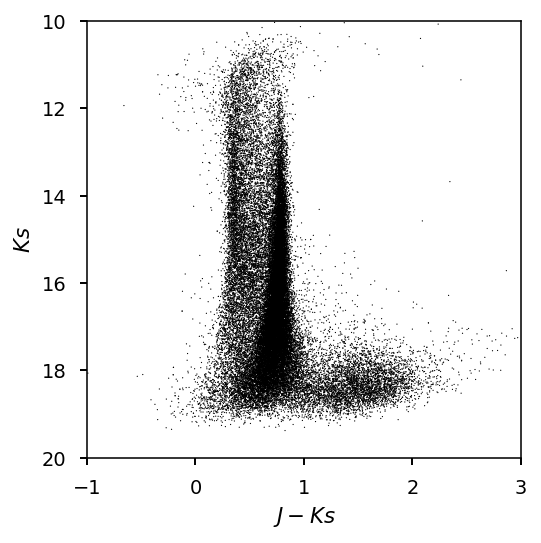

In [64]:
import matplotlib.pyplot as plt
#selected = v_flux['f_vista_y'] / v_flux['ferr_vista_y'] > 5
#selected &= v_flux['f_vista_ks'] / v_flux['ferr_vista_ks'] > 5
plt.style.use('seaborn-notebook')
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(v_flux['vhs_m_ap_vista_j'] - v_flux['vhs_m_ap_vista_ks'],
            v_flux['vhs_m_ap_vista_ks'],
            edgecolors='None', s=0.4, c='k')
plt.xlim(-1, 3)
plt.ylim(20, 10)
plt.xlabel('$J-Ks$')
plt.ylabel('$Ks$')
plt.subplots_adjust(left=0.125, bottom=0.1)
plt.show()

In [15]:
import logging
LOGGER = logging.getLogger(__name__)
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
from collections import Counter
from astropy.table import Table, Column, hstack, vstack
def merge_catalogues(cat_1, cat_2, racol_2, decol_2, radius=0.4*u.arcsec):
    """Merge two catalogues
    This function merges the second catalogue into the first one using the
    given radius to associate identical sources.  This function takes care to
    associate only one source of one catalogue to the other.  The sources that
    may be associated to various counterparts in the other catalogue are
    flagged as “maybe spurious association” with a true value in the
    flag_merged column.  If this column is present in the first catalogue, it's
    content is “inherited” during the merge.
    Parameters
    ----------
    cat_1: astropy.table.Table
        The table containing the first catalogue.  This is the master catalogue
        used during the merge.  If it has a “flag_merged” column it's content
        will be re-used in the flagging of the spurious merges.  This catalogue
        must contain a ‘ra’ and a ‘dec’ columns with the position in decimal
        degrees.
    cat_2: astropy.table.Table
        The table containing the second catalogue.
    racol_2: string
        Name of the column in the second table containing the right ascension
        in decimal degrees.
    decol_2: string
        Name of the column in the second table containing the declination in
        decimal degrees.
    radius: astropy.units.quantity.Quantity
        The radius to associate identical sources in the two catalogues.
    Returns
    -------
    astropy.table.Table
        The merged catalogue.
    """
    cat_1 = cat_1.copy()
    cat_2 = cat_2.copy()
    cat_1['ra'].unit = u.rad
    cat_1['dec'].unit = u.rad
    coords_1 = SkyCoord(cat_1['ra'], cat_1['dec'])

    
    cat_2[racol_2].unit = u.rad
    cat_2[decol_2].unit = u.rad
    coords_2 = SkyCoord(cat_2[racol_2], cat_2[decol_2])

    # Search for sources in second catalogue matching the sources in the first
    # one.
    idx_2, idx_1, d2d, _ = coords_1.search_around_sky(coords_2, radius)

    # We want to flag the possible mis-associations, i.e. the sources in each
    # catalogue that are associated to several sources in the other one, but
    # also all the sources that are associated to a problematic source in the
    # other catalogue (e.g. if two sources in the first catalogue are
    # associated to the same source in the second catalogue, they must be
    # flagged as potentially problematic).
    #
    # Search for duplicate associations
    toflag_idx_1 = np.unique([item for item, count in Counter(idx_1).items()
                              if count > 1])
    toflag_idx_2 = np.unique([item for item, count in Counter(idx_2).items()
                              if count > 1])
    # Flagging the sources associated to duplicates
    dup_associated_in_idx1 = np.in1d(idx_2, toflag_idx_2)
    dup_associated_in_idx2 = np.in1d(idx_1, toflag_idx_1)
    toflag_idx_1 = np.unique(np.concatenate(
        (toflag_idx_1, idx_1[dup_associated_in_idx1])
    ))
    toflag_idx_2 = np.unique(np.concatenate(
        (toflag_idx_2, idx_2[dup_associated_in_idx2])
    ))

    # Adding the flags to the catalogue.  In the second catalogue, the column
    # is named "flag_merged_2" and will be combined to the flag_merged column
    # one the merge is done.
    try:
        cat_1["flag_merged"] |= np.in1d(np.arange(len(cat_1), dtype=int),
                                        toflag_idx_1)
    except KeyError:
        cat_1.add_column(Column(
            data=np.in1d(np.arange(len(cat_1), dtype=int), toflag_idx_1),
            name="flag_merged"
        ))
    try:
        cat_2["flag_merged_2"] |= np.in1d(np.arange(len(cat_2), dtype=int), toflag_idx_2)
    except KeyError:
        cat_2.add_column(Column(
            data=np.in1d(np.arange(len(cat_2), dtype=int), toflag_idx_2),
            name="flag_merged_2"
        ))


    # Now that we have flagged the maybe spurious associations, we want to
    # associate each source of each catalogue to at most one source in the
    # other one.

    # We sort the indices by the distance to take the nearest counterparts in
    # the following steps.
    sort_idx = np.argsort(d2d)
    idx_1 = idx_1[sort_idx]
    idx_2 = idx_2[sort_idx]

    # These array will contain the indexes of the matching sources in both
    # catalogues.
    match_idx_1 = np.array([], dtype=int)
    match_idx_2 = np.array([], dtype=int)

    while len(idx_1) > 0:

        both_first_idx = np.sort(np.intersect1d(
            np.unique(idx_1, return_index=True)[1],
            np.unique(idx_2, return_index=True)[1],
        ))

        new_match_idx_1 = idx_1[both_first_idx]
        new_match_idx_2 = idx_2[both_first_idx]

        match_idx_1 = np.concatenate((match_idx_1, new_match_idx_1))
        match_idx_2 = np.concatenate((match_idx_2, new_match_idx_2))

        # We remove the matching sources in both catalogues.
        to_remove = (np.in1d(idx_1, new_match_idx_1) |
                     np.in1d(idx_2, new_match_idx_2))
        idx_1 = idx_1[~to_remove]
        idx_2 = idx_2[~to_remove]

    # Indices of un-associated object in both catalogues.
    unmatched_idx_1 = np.delete(np.arange(len(cat_1), dtype=int),match_idx_1)
    unmatched_idx_2 = np.delete(np.arange(len(cat_2), dtype=int),match_idx_2)

    # Sources only in cat_1
    only_in_cat_1 = cat_1[unmatched_idx_1]

    # Sources only in cat_2
    only_in_cat_2 = cat_2[unmatched_idx_2]
    # We are using the ra and dec columns from cat_2 for the position.
    only_in_cat_2[racol_2].name = "ra"
    only_in_cat_2[decol_2].name = "dec"

    # Merged table of sources in both catalogues.
    both_in_cat_1_and_cat_2 = hstack([cat_1[match_idx_1], cat_2[match_idx_2]])
    # We don't need the positions from the second catalogue anymore.
    both_in_cat_1_and_cat_2.remove_columns([racol_2, decol_2])

    # Logging the number of rows
    LOGGER.info("There are %s sources only in the first catalogue",
                len(only_in_cat_1))
    LOGGER.info("There are %s sources only in the second catalogue",
                len(only_in_cat_2))
    LOGGER.info("There are %s sources in both catalogues",
                len(both_in_cat_1_and_cat_2))

    merged_catalogue = vstack([only_in_cat_1, both_in_cat_1_and_cat_2,
                               only_in_cat_2])

    # When vertically stacking the catalogues, some values in the flag columns
    # are masked because they did not exist in the catalogue some row originate
    # from. We must set them to the appropriate value.
    for colname in merged_catalogue.colnames:
        if 'flag' in colname:
            merged_catalogue[colname][merged_catalogue[colname].mask] = False

    # We combined the flag_merged flags
    merged_catalogue['flag_merged'] |= merged_catalogue['flag_merged_2']
    merged_catalogue.remove_column('flag_merged_2')
    merged_catalogue.remove_column('flag_merged')
    return merged_catalogue

In [16]:
r_cat = Table.read("../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110_GmagLT19/133200.fits")

In [17]:
col_dict={
'flags':'1X',
 'id':'1K',
 'coord_ra':'1D',
 'coord_dec':'1D',
 'g_flux':'1D',
 'r_flux':'1D',
 'i_flux':'1D',
 'z_flux':'1D',
 'y_flux':'1D',
 'g_fluxErr':'1D',
 'r_fluxErr':'1D',
 'i_fluxErr':'1D',
 'z_fluxErr':'1D',
 'y_fluxErr':'1D',
 'j_flux':'1D',
 'j_fluxErr':'1D',
 'h_flux':'1D',
 'h_fluxErr':'1D',
 'ks_flux':'1D',
 'ks_fluxErr':'1D',
    'g':'1D',
    'g_err':'1D',
    'r':'1D',
    'r_err':'1D',
    'i':'1D',
    'i_err':'1D',
    'z':'1D',
    'z_err':'1D',
    'y':'1D',
    'y_err':'1D',
    'j':'1D',
    'j_err':'1D',
    'h':'1D',
    'h_err':'1D',
    'ks':'1D',
    'ks_err':'1D',
    'k':'1D',
    'k_err':'1D',
 'coord_raErr':'1E',
 'coord_decErr':'1E',
 'epoch':'1D',
 'pm_ra':'1D',
 'pm_dec':'1D',
 'pm_raErr':'1E',
 'pm_decErr':'1E',
 'parent':'1K',
 'footprint':'1J',

}

cls_dict={
'flags':'',
 'id':'',
 'coord_ra':'Angle',
 'coord_dec':'Angle',
 'g_flux':'Scalar',
 'r_flux':'Scalar',
 'i_flux':'Scalar',
 'z_flux':'Scalar',
 'y_flux':'Scalar',
 'g_fluxErr':'Scalar',
 'r_fluxErr':'Scalar',
 'i_fluxErr':'Scalar',
 'z_fluxErr':'Scalar',
 'y_fluxErr':'Scalar',
 'j_flux':'Scalar',
 'j_fluxErr':'Scalar',
 'h_flux':'Scalar',
 'h_fluxErr':'Scalar',
 'ks_flux':'Scalar',
 'ks_fluxErr':'Scalar',
    'g':'Scalar',
    'g_err':'Scalar',
    'r':'Scalar',
    'r_err':'Scalar',
    'i':'Scalar',
    'i_err':'Scalar',
    'z':'Scalar',
    'z_err':'Scalar',
    'y':'Scalar',
    'y_err':'Scalar',
    'j':'Scalar',
    'j_err':'Scalar',
    'h':'Scalar',
    'h_err':'Scalar',
    'ks':'Scalar',
    'ks_err':'Scalar',
    'k':'Scalar',
    'k_err':'Scalar',
 'coord_raErr':'Scalar',
 'coord_decErr':'Scalar',
 'epoch':'Scalar',
 'pm_ra':'Angle',
 'pm_dec':'Angle',
 'pm_raErr':'Scalar',
 'pm_decErr':'Scalar',
 'parent':'Scalar',
 'footprint':'Scalar',

}

unit_dict={
'flags':'',
 'id':'',
 'coord_ra':'deg',
 'coord_dec':'deg',
 'g_flux':'Jy',
 'r_flux':'Jy',
 'i_flux':'Jy',
 'z_flux':'Jy',
 'y_flux':'Jy',
 'g_fluxErr':'Jy',
 'r_fluxErr':'Jy',
 'i_fluxErr':'Jy',
 'z_fluxErr':'Jy',
 'y_fluxErr':'Jy',
 'j_flux':'Jy',
 'j_fluxErr':'Jy',
 'h_flux':'Jy',
 'h_fluxErr':'Jy',
 'ks_flux':'Jy',
 'ks_fluxErr':'Jy',
    'g':'mag',
    'g_err':'mag',
    'r':'mag',
    'r_err':'mag',
    'i':'mag',
    'i_err':'mag',
    'z':'mag',
    'z_err':'mag',
    'y':'mag',
    'y_err':'mag',
    'j':'mag',
    'j_err':'mag',
    'h':'mag',
    'h_err':'mag',
    'ks':'mag',
    'ks_err':'mag',
    'k':'mag',
    'k_err':'mag',
 'coord_raErr':'deg',
 'coord_decErr':'deg',
 'epoch':'day',
 'pm_ra':'deg',
 'pm_dec':'deg',
 'pm_raErr':'deg/year',
 'pm_decErr':'deg/year',
 'parent':'',
 'footprint':'',
}

docs_dict={
'flags':'',
 'id':'',
 'coord_ra':'',
 'coord_dec':'',
 'g_flux':'',
 'r_flux':'',
 'i_flux':'',
 'z_flux':'',
 'y_flux':'',
 'g_fluxErr':'',
 'r_fluxErr':'',
 'i_fluxErr':'',
 'z_fluxErr':'',
 'y_fluxErr':'',
 'j_flux':'',
 'j_fluxErr':'',
 'h_flux':'',
 'h_fluxErr':'',
 'ks_flux':'',
 'ks_fluxErr':'',
    'g':'',
    'g_err':'',
    'r':'',
    'r_err':'',
    'i':'',
    'i_err':'',
    'z':'',
    'z_err':'',
    'y':'',
    'y_err':'',
    'j':'',
    'j_err':'',
    'h':'',
    'h_err':'',
    'ks':'',
    'ks_err':'',
    'k':'',
    'k_err':'',
 'coord_raErr':'',
 'coord_decErr':'',
 'epoch':'',
 'pm_ra':'',
 'pm_dec':'',
 'pm_raErr':'',
 'pm_decErr':'',
 'parent':'',
 'footprint':'',
}

In [61]:
#VHS REF CAT
for c in ps_refcats:
    r_cat = Table.read("../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110/{}.fits".format(c))
    r_cat['coord_ra'].name = 'ra'
    r_cat['coord_dec'].name = 'dec'
    merge = merge_catalogues(r_cat, v_flux, 'vhs_ra', 'vhs_dec', radius=0.4*u.arcsec)
    merge=clean_table(merge)
    has_both  = (
        (merge['g_flux'] >0.)
        # &(merge['vhs_m_ap_vista_ks']>0.) #Take all panstarrs objects
    )
    merge['ra'].name = 'coord_ra'
    merge['dec'].name = 'coord_dec'
    #convert rad to degs?
    merge['coord_ra'] = (180./np.pi)*merge['coord_ra']
    merge['coord_ra'].unit = u.deg
    merge['coord_dec'] = (180./np.pi)*merge['coord_dec']
    merge['coord_dec'].unit = u.deg
    merge['pm_ra_err'].name = 'pm_raErr'
    merge['pm_dec_err'].name = 'pm_decErr'
    try:
        merge['coord_raErr'] = (180./np.pi)*merge['coord_ra_err']
        merge['coord_raErr'].unit = u.deg
        merge['coord_decErr'] = (180./np.pi)*merge['coord_dec_err']
        merge['coord_decErr'].unit = u.deg
        merge.remove_columns['coord_ra_err', 'coord_dec_err']
    except:
        merge['coord_raErr'] = (180./np.pi)*merge['coord_raErr']
        merge['coord_raErr'].unit = u.deg
        merge['coord_decErr'] = (180./np.pi)*merge['coord_decErr']
        merge['coord_decErr'].unit = u.deg
    #flags col only in James Mulaney 19 cut cat
    #merge['flags'].format = '1X'
    merge['epoch'] = merge['epoch'].astype('int32')
    #merge[has_both].write('./data/refcats/{}.fits'.format(c), overwrite=True)
    merge = merge[has_both]
    for col in merge.colnames:
        #go through every flux column and convert to mags and rename
        if col.endswith('_flux'):
            err_col = col + 'Sigma'
            mag = abMagFromFlux(merge[col])
            mag_err = abMagErrFromFluxErr(merge[err_col],merge[col])
            merge[col] = mag
            merge[col].name = col[:-5]
            merge[err_col] = mag_err
            merge[err_col].name = err_col.replace('fluxSigma','err')
        #Go through every vhs mag col and rename
        if col.startswith('vhs_m_'):
            merge[col].name =col.split('_')[-1]
            merge[col.replace('vhs_m_', 'vhs_merr_')].name =  col.split('_')[-1] + '_err'
    merge.remove_columns(['vhs_stellarity', 'vhs_id'])
    merge.write('./data/ref_cats_vhs/{}.fits'.format(c), overwrite=True)
    print("Shard {} has {} objects and {} VHS mags.".format(c, len(merge), np.sum(~np.isnan(merge['ks']))))
    #f = fits.BinTableHDU.from_columns([
    #fits.Column(
    #    name=merge[col].name,
    #    array=merge[col].data, 
    #    format=col_dict[col]) 
    #for col in merge.colnames
    #])
    #f.header['AFW_TYPE']= 'SIMPLE'
    #f.header['HIERARCH AFW_TABLE_VERSION'] = 3 
    #f.header['FLAGCOL'] = 1
    #f.header['TFLAG1'] = 'pm_flag'
    #for key in f.header:
    #    if key.startswith('TFORM'):
    #        num = key[5:]
    #        if not cls_dict[f.header['TTYPE'+str(num)]]=='':
    #            f.header['TCCLS'+str(num)] = cls_dict[f.header['TTYPE'+str(num)]]
    #            
    #        if not unit_dict[f.header['TTYPE'+str(num)]]=='':
    #            f.header['TUNIT'+str(num)] = unit_dict[f.header['TTYPE'+str(num)]]
    #        f.header['TDOC'+str(num)] = docs_dict[f.header['TTYPE'+str(num)]]
    # 
    #f.writeto('./data/ref_cats_vhs/{}.fits'.format(c), overwrite=True)

Shard 133200 has 12877 objects and 620 VHS mags.
Shard 133201 has 12581 objects and 880 VHS mags.
Shard 133202 has 14150 objects and 683 VHS mags.
Shard 133203 has 13422 objects and 427 VHS mags.
Shard 133204 has 11331 objects and 458 VHS mags.
Shard 133205 has 13146 objects and 560 VHS mags.
Shard 133206 has 13264 objects and 659 VHS mags.
Shard 133207 has 12471 objects and 697 VHS mags.
Shard 133208 has 17783 objects and 627 VHS mags.
Shard 133209 has 11969 objects and 395 VHS mags.
Shard 133210 has 14566 objects and 790 VHS mags.
Shard 133211 has 12661 objects and 240 VHS mags.
Shard 133212 has 13815 objects and 645 VHS mags.
Shard 133213 has 14287 objects and 529 VHS mags.
Shard 133214 has 12922 objects and 587 VHS mags.
Shard 133215 has 12812 objects and 675 VHS mags.
Shard 133232 has 11349 objects and 210 VHS mags.
Shard 133234 has 13192 objects and 557 VHS mags.
Shard 133235 has 13873 objects and 218 VHS mags.
Shard 133240 has 20840 objects and 421 VHS mags.
Shard 133241 has 146

In [62]:
c

134095

In [63]:
merge[:5]

id,coord_ra,coord_dec,parent,g,r,i,z,y,i_err,y_err,r_err,z_err,g_err,coord_ra_err,coord_dec_err,epoch,pm_ra,pm_dec,pm_raErr,pm_decErr,footprint,j,j_err,h,h_err,ks,ks_err,coord_raErr,coord_decErr
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,int32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32
98990330661167253,33.066134207549176,-7.502640348339388,0,23.094601638043926,23.18275455632343,22.330112478207308,22.22099074201438,21.37183898914165,0.13758970682129018,0.2512690051684425,0.18505775767356358,0.13986468253865827,0.1413276205937947,0.0,0.0,1335728000,0.0,0.0,0.0,0.0,0,nan,nan,nan,nan,nan,nan,0.0,0.0
98970330676116961,33.06762515076874,-7.519612591211864,0,23.494627508655892,22.242820222814835,22.602331689755246,22.255039280590367,21.531894219499463,0.09025217590608887,0.16786358273582666,0.21137090312577234,0.18763903536161067,0.2776551236436671,0.0,0.0,1336069632,0.0,0.0,0.0,0.0,0,nan,nan,nan,nan,nan,nan,0.0,0.0
98990330697742613,33.06985482341629,-7.506339619540643,0,23.04444319421623,22.20646381478897,22.000413005771563,21.402814395361446,21.09598635880582,0.07762026595858049,0.16734576772647292,0.07804401016670204,0.08225527865685545,0.12455416362567538,0.0,0.0,1342961152,0.081276685,0.22237486,0.07771046,0.07771046,0,nan,nan,nan,nan,nan,nan,0.0,0.0
98980330710415893,33.0711286230315,-7.512105567684777,0,23.714089349560798,22.560291370726233,21.763067174753516,21.331529617320697,20.7128024319301,0.045667688648126196,0.15468306861033232,0.17547329890461227,0.12641089419177426,0.3049035285549112,0.0,0.0,1359296512,0.02925853,-0.014672493,0.036659826,0.03669918,0,nan,nan,nan,nan,nan,nan,0.0,0.0
98960330710553089,33.07105979461775,-7.531104947369024,0,23.59803910759777,22.567007548181287,22.283813926522072,22.007176919545866,21.0614991529393,0.12192708877091846,0.19067346133866364,0.2497691000925989,0.14341708107688683,0.4823038540555836,0.0,0.0,1350822528,0.0,0.0,0.0,0.0,0,nan,nan,nan,nan,nan,nan,0.0,0.0


In [58]:
len(merge)

14239

In [36]:
np.sum(~np.isnan(merge['ks']))

0

## 2MASS equivalent

Finally we aim to repeat the VISTA calibration by directly using the 2MASS catalogues. This will allow a consistent reference across the sky and reduce noise introduced by useing the original VISTA catalogues.

In [22]:
c_2mass = Table.read(MASS_CAT, format = 'ascii')

In [23]:
#c_2mass.write(MASS_CAT + '.fits')

In [24]:
c_2mass[:10].show_in_notebook()

idx,ra,dec,err_maj,err_min,err_ang,designation,j_m,j_cmsig,j_msigcom,j_snr,h_m,h_cmsig,h_msigcom,h_snr,k_m,k_cmsig,k_msigcom,k_snr,ph_qual,rd_flg,bl_flg,cc_flg,ndet,prox,pxpa,pxcntr,gal_contam,mp_flg,jdate,j_h,h_k,j_k
,deg,deg,arcsec,arcsec,deg,,mag,mag,mag,,mag,mag,mag,,mag,mag,mag,,,,,,,arcsec,deg,,,,jdate,,,
0,33.000502,-6.229199,0.09,0.09,82,02120012-0613451,15.391,0.063,0.064,19.8,15.075,0.1,0.1,11.3,15.228,0.195,0.195,5.8,AAC,222,111,000,260606,68.9,158,191588580,0,0,2451160.529,0.316,-0.153,0.163
1,33.000603,-4.621639,0.07,0.06,90,02120014-0437179,14.624,0.03,0.032,58.6,13.989,0.034,0.035,37.9,13.836,0.042,0.043,28.3,AAA,222,111,000,665555,14.4,20,1330939424,0,0,2451069.7686,0.635,0.153,0.788
2,33.000681,-6.909555,0.06,0.06,0,02120016-0654343,13.46,0.026,0.029,117.1,13.174,0.027,0.028,65.2,13.017,0.037,0.038,44.1,AAA,222,111,000,666666,52.8,345,191589544,0,0,2451160.5295,0.286,0.157,0.443
3,33.000963,-3.064814,0.14,0.14,87,02120023-0303533,16.012,0.074,0.075,16.3,15.453,0.103,0.104,9.8,15.087,0.126,0.127,9.0,ABB,222,111,000,160505,20.2,158,1330937119,0,0,2451069.7674,0.559,0.366,0.925
4,33.00114,-4.343209,0.18,0.16,135,02120027-0420355,16.515,0.148,0.149,10.3,15.655,0.139,0.14,8.2,15.173,--,--,--,BBU,226,220,cc0,262600,3.1,102,1330938997,0,0,2451069.7684,0.86,--,--
5,33.001205,-4.639122,0.2,0.19,65,02120028-0438208,16.196,0.078,0.079,13.8,15.626,0.127,0.127,8.4,15.425,0.173,0.173,6.5,ABC,222,111,000,260606,38.7,303,1330939447,0,0,2451069.7686,0.57,0.201,0.771
6,33.001259,-4.118789,0.08,0.07,88,02120030-0407076,14.422,0.021,0.024,70.6,13.895,0.02,0.022,41.3,13.729,0.044,0.045,31.2,AAA,222,111,000,665555,85.3,86,1330938701,0,0,2451069.7682,0.527,0.166,0.693
7,33.001546,-4.47142,0.07,0.06,85,02120037-0428171,15.385,0.039,0.041,29.1,14.754,0.059,0.059,18.7,14.546,0.077,0.077,14.7,AAA,222,111,000,662616,47.1,148,1330939204,0,0,2451069.7685,0.631,0.208,0.839
8,33.001597,-3.103978,0.19,0.17,3,02120038-0306143,16.499,0.106,0.107,10.4,15.748,0.127,0.127,7.5,15.307,0.168,0.168,7.3,ABC,222,111,000,060604,60.1,117,1330937180,0,0,2451069.7675,0.751,0.441,1.192


In [25]:
c_2mass['ra'].name = 'v_ra'
c_2mass['dec'].name = 'v_dec'
c_2mass['j_m'].name = 'j'
c_2mass['j_cmsig'].name = 'j_err'
c_2mass['h_m'].name = 'h'
c_2mass['h_cmsig'].name = 'h_err'
c_2mass['k_m'].name = 'ks'
c_2mass['k_cmsig'].name = 'ks_err'
c_2mass = c_2mass['v_ra', 'v_dec', 'j','j_err','h','h_err','ks','ks_err']

In [26]:
c_2mass['v_ra'].convert_unit_to(u.rad)
c_2mass['v_dec'].convert_unit_to(u.rad)

In [43]:
len(c_2mass)

31383

In [42]:
c_2mass[:5]

v_ra,v_dec,j,j_err,h,h_err,ks,ks_err
rad,rad,mag,mag,mag,mag,mag,mag
float64,float64,float64,float64,float64,float64,float64,float64
0.5759674147109737,-0.10872003231193826,15.391,0.063,15.075,0.1,15.228,0.195
0.5759691774935183,-0.08066281738857821,14.624,0.03,13.989,0.034,13.836,0.042
0.5759705388503349,-0.1205944845976368,13.46,0.026,13.174,0.027,13.017,0.037
0.5759754606788254,-0.053491095261217494,16.012,0.074,15.453,0.103,15.087,0.126
0.5759785499116015,-0.0758032971522504,16.515,0.148,15.655,0.139,15.173,--


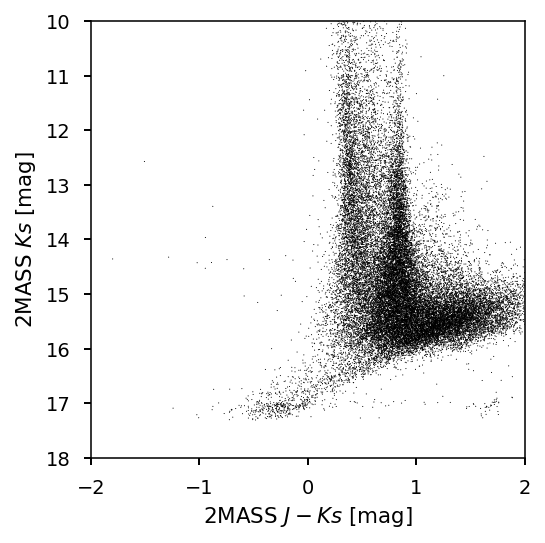

In [47]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-notebook')
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(c_2mass['j'] - c_2mass['ks'],
            c_2mass['ks'],
            edgecolors='None', s=0.3, c='k')
plt.xlim(-2, 2)
plt.ylim(18, 10)
plt.xlabel('2MASS $J-Ks$ [mag]')
plt.ylabel('2MASS $Ks$ [mag]')
plt.subplots_adjust(left=0.125, bottom=0.1)
plt.show()

In [49]:
PS_CATS19

'../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110_GmagLT19/'

In [54]:
for c in ps_refcats:
    r_cat = Table.read("{}/{}.fits".format(PS_CATS,c))
    r_cat['coord_ra'].name = 'ra'
    r_cat['coord_dec'].name = 'dec'
    merge = merge_catalogues(r_cat, c_2mass, 'v_ra', 'v_dec', radius=0.4*u.arcsec)
    has_both  = (
        (merge['g_flux'] >0.)
        # &(merge['ks']>0.)
         
    )
    merge['ra'].name = 'coord_ra'
    merge['dec'].name = 'coord_dec'
    #convert rad to degs
    merge['coord_ra'] = (180./np.pi)*merge['coord_ra']
    merge['coord_ra'].unit = u.deg
    merge['coord_dec'] = (180./np.pi)*merge['coord_dec']
    merge['coord_dec'].unit = u.deg
    try:
        merge['coord_raErr'] = (180./np.pi)*merge['coord_ra_err']
        merge['coord_raErr'].unit = u.deg
        merge['coord_decErr'] = (180./np.pi)*merge['coord_dec_err']
        merge['coord_decErr'].unit = u.deg
        merge.remove_columns['coord_ra_err', 'coord_dec_err']
    except:
        merge['coord_raErr'] = (180./np.pi)*merge['coord_raErr']
        merge['coord_raErr'].unit = u.deg
        merge['coord_decErr'] = (180./np.pi)*merge['coord_decErr']
        merge['coord_decErr'].unit = u.deg
    #flags col only in James Mulaney 19 cut cat
    #merge['flags'].format = '1X'
    merge['epoch'] = merge['epoch'].astype('int32')
    #merge[has_both].write('./data/refcats/{}.fits'.format(c), overwrite=True)
    merge = merge[has_both]
    for col in merge.colnames:
        #go through every flux column and convert to mags and rename
        if col.endswith('_flux'):
            full_cat = False
            if full_cat:
                err_col = col + 'Sigma'
                mag = abMagFromFlux(merge[col])
                mag_err = abMagErrFromFluxErr(merge[err_col],merge[col])
                merge[col] = mag
                merge[col].name = col[:-5]
                merge[err_col] = mag_err
                merge[err_col].name = err_col.replace('fluxSigma', 'err')
                merge['pm_ra_err'].name = 'pm_raErr'
                merge['pm_dec_err'].name = 'pm_raErr'
            else:
                err_col = col + 'Err'
                mag = abMagFromFlux(merge[col])
                mag_err = abMagErrFromFluxErr(merge[err_col],merge[col])
                merge[col] = mag
                merge[col].name = col[:-5]
                merge[err_col] = mag_err
                merge[err_col].name = err_col.replace('fluxSigma', 'err')
    print("Shard {} has {} objects and {} 2MASS mags.".format(c, len(merge), np.sum(~np.isnan(merge['ks']))))
    merge.write('./data/refcats_2mass/{}.fits'.format(c), overwrite=True)
    #f = fits.BinTableHDU.from_columns([
    #fits.Column(
    #    name=merge[col].name,
    #    array=merge[col].data, 
    #    format=col_dict[col]) 
    #for col in merge.colnames
    #])
    #f.header['AFW_TYPE']= 'SIMPLE'
    #f.header['HIERARCH AFW_TABLE_VERSION'] = 3 
    #f.header['FLAGCOL'] = 1
    #f.header['TFLAG1'] = 'pm_flag'
    #for key in f.header:
    #    if key.startswith('TFORM'):
    #        num = key[5:]
    #        if not cls_dict[f.header['TTYPE'+str(num)]]=='':
    #            f.header['TCCLS'+str(num)] = cls_dict[f.header['TTYPE'+str(num)]]
    #            
    #        if not unit_dict[f.header['TTYPE'+str(num)]]=='':
    #            f.header['TUNIT'+str(num)] = unit_dict[f.header['TTYPE'+str(num)]]
    #        f.header['TDOC'+str(num)] = docs_dict[f.header['TTYPE'+str(num)]]
    # 
    #f.writeto('./data/refcats_2mass/{}.fits'.format(c), overwrite=True)

Shard 133200 has 250 objects and 171 2MASS mags.


Shard 133201 has 238 objects and 143 2MASS mags.
Shard 133202 has 212 objects and 145 2MASS mags.
Shard 133203 has 252 objects and 173 2MASS mags.
Shard 133204 has 250 objects and 176 2MASS mags.
Shard 133205 has 270 objects and 183 2MASS mags.
Shard 133206 has 223 objects and 142 2MASS mags.
Shard 133207 has 234 objects and 140 2MASS mags.
Shard 133208 has 273 objects and 175 2MASS mags.
Shard 133209 has 225 objects and 145 2MASS mags.
Shard 133210 has 238 objects and 148 2MASS mags.
Shard 133211 has 232 objects and 161 2MASS mags.
Shard 133212 has 242 objects and 151 2MASS mags.
Shard 133213 has 281 objects and 153 2MASS mags.
Shard 133214 has 227 objects and 150 2MASS mags.
Shard 133215 has 222 objects and 160 2MASS mags.
Shard 133232 has 253 objects and 20 2MASS mags.
Shard 133234 has 307 objects and 30 2MASS mags.
Shard 133235 has 251 objects and 1 2MASS mags.
Shard 133240 has 312 objects and 12 2MASS mags.
Shard 133241 has 266 objects and 22 2MASS mags.
Shard 133243 has 250 objec

In [53]:
merge[:5]

flags [1],id,coord_ra,coord_dec,g_flux,r_flux,i_flux,z_flux,y_flux,g_fluxErr,r_fluxErr,i_fluxErr,z_fluxErr,y_fluxErr,coord_raErr,coord_decErr,epoch,pm_ra,pm_dec,pm_raErr,pm_decErr,parent,footprint,j,j_err,h,h_err,ks,ks_err
,,deg,deg,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,deg,deg,day,rad,rad,rad/year,rad/year,,,mag,mag,mag,mag,mag,mag
bool,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,int32,float64,float64,float32,float32,int64,int32,float64,float64,float64,float64,float64,float64
False,101190348981625762,34.89819512471602,-5.670540792842465,0.0001781752653187138,0.0003035893314518027,0.00038027288974262704,0.0004167810257058586,0.00045603542821481846,2.893226564992797e-06,1.7455827219237068e-06,1.3382312999965481e-06,1.0650850299498403e-06,6.668332844128603e-06,0.0,0.0,1411668096,4.890680979280116e-11,1.8592115247514537e-11,1.2868463e-11,1.371196e-11,0,0,--,--,--,--,--,--
False,100960349275571520,34.927550977546076,-5.865782499373869,0.005736374296247959,0.008477262221276746,0.009547810070216663,0.009837229736149302,0.010142857208847986,3.68190958397463e-05,8.434118171862777e-06,1.4768573237233805e-05,4.2388008296256844e-05,4.340290252002882e-05,0.0,0.0,1413335936,-3.414886737566814e-11,-1.1982154244149313e-10,1.6616208e-11,1.7279738e-11,0,0,--,--,--,--,--,--
False,100990349386034226,34.93859808959108,-5.838488805493738,0.00014868594007566569,0.0001359257730655372,0.000117627547297161,0.00011287334200460472,0.00011824300599982943,5.447240596367918e-07,1.0245927342111825e-06,5.996064373903205e-07,7.909019359431119e-07,6.734151156706492e-07,0.0,0.0,1416500736,-2.591155720396198e-11,-2.023784164694938e-11,1.9852918e-11,2.7202978e-11,0,0,--,--,--,--,--,--
False,101210349546388237,34.954651556659485,-5.651814261153591,0.00014338202890940008,0.00017356607713736577,0.0001841539924498648,0.00018508237553760426,0.00018404645379632725,1.0464729029990847e-06,1.1526192338351383e-06,9.174671617984134e-07,1.073331645784493e-06,3.0983342185209065e-06,0.0,0.0,1412359296,-7.392671391227056e-12,-6.076544950230361e-11,1.0234514e-11,2.0225158e-11,0,0,--,--,--,--,--,--
False,100930349609212471,34.96094101347726,-5.890011142806678,0.0006671867449767887,0.0019209033343940978,0.0034359330311417476,0.0044839228503406065,0.005187057889997956,2.8098354505345924e-06,6.691072030662327e-06,1.668416371103371e-05,1.9636376237031076e-05,9.817134014156175e-06,0.0,0.0,1408557696,7.863787000973867e-11,-1.6785090390374422e-10,1.3091004e-11,7.959912e-12,0,0,--,--,--,--,--,--


In [29]:
htm = HtmIndexer(depth=7)
#htm.